##Install Libraries

In [ ]:
!git --version

git version 2.17.1


In [1]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install audiolazy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 121 kB 4.6 MB/s 


##Import Libraries

In [95]:
import numpy as np
import pandas as pd
import matplotlib
import scipy
import seaborn
import librosa
import audiolazy
import sklearn
import os
import glob
import shutil

import scipy.signal as sig
from audiolazy import lazy_lpc
from itertools import cycle
import warnings
import sys

%matplotlib inline
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

# ignore warnings 
if not sys.warnoptions:
  warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

##Data Preparation

In [59]:
# Create variable for raw dataset's path
#dtsets1 = '/content/drive/MyDrive/Dataset TA/NewDataPrimer'

dtsets = '/content/drive/MyDrive/DataSpeechs'
type_emotions = ['bahagia', 'kecewa', 'marah', 'sedih']  # Type of emotion to be classified

In [60]:
print(os.listdir(dtsets))

['Salman', 'Aka', 'Tasya', 'Syahri', 'Erzal', 'Sabda', 'Febby', 'Sarah', 'Citra', 'Raina']


In [61]:
'''
Because the dataset used has not been separated according to the type of emotion and the model used is Unsupervised Learning,
it is necessary to separate it according to the type of emotion first.
'''

# Create list to store emotion and path
emotions = []
paths = []

for foldername in sorted(os.listdir(dtsets)):
  folder = os.path.join(dtsets, foldername)
  #print(folder)

  i = 0   # Variable for the process of separation of emotions 
  for filename in sorted(os.listdir(folder)):
    #print(filename)
    file_path = os.path.join(folder, filename)
    #print(file_path)
    
    # The process of separation of emotions
    if i <= 9:
      emotions.append('bahagia')
      paths.append(file_path)
    elif i in range(10, 20):
      emotions.append('marah')
      paths.append(file_path)
    elif i in range(20, 30):
      emotions.append('kecewa')
      paths.append(file_path)
    else:
      emotions.append('sedih')
      paths.append(file_path)
    
    # Increase the value of i when each one of the loop processes is finished
    i += 1

In [89]:
dtsets_df = pd.DataFrame(emotions, columns= ['labels'])
dtsets_df = pd.concat([dtsets_df, pd.DataFrame(paths, columns = ['path'])], axis = 1)

dtsets_df.labels.value_counts()

bahagia    100
marah      100
kecewa     100
sedih      100
Name: labels, dtype: int64

In [63]:
dtsets_df.head(15)

,labels,path
0,bahagia,/content/drive/MyDrive/DataSpeechs/Aka/Recordi...
1,bahagia,/content/drive/MyDrive/DataSpeechs/Aka/Recordi...
2,bahagia,/content/drive/MyDrive/DataSpeechs/Aka/Recordi...
3,bahagia,/content/drive/MyDrive/DataSpeechs/Aka/Recordi...
4,bahagia,/content/drive/MyDrive/DataSpeechs/Aka/Recordi...
5,bahagia,/content/drive/MyDrive/DataSpeechs/Aka/Recordi...
6,bahagia,/content/drive/MyDrive/DataSpeechs/Aka/Recordi...
7,bahagia,/content/drive/MyDrive/DataSpeechs/Aka/Recordi...
8,bahagia,/content/drive/MyDrive/DataSpeechs/Aka/Recordi...
9,bahagia,/content/drive/MyDrive/DataSpeechs/Aka/Recordi...


In [64]:
dtsets_df.to_csv("Data_path.csv",index=False)

###Data Exploration
<p align="justify"> In this section, exploratory data will be carried out to see how the conditions of the dataset that we will use are. We will plot 1 or 2 speech data randomly for each type of emotion. This is done to get a feel for what kind of data we will use. For example, does the data contain a lot of noise? Is the pronunciation clear? etc. If the data we use is difficult for humans to interpret, of course the model will also be difficult to do. </p>

In [90]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa.display
import seaborn as sns

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


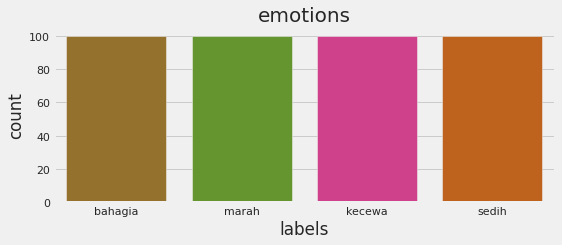

In [96]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (8, 3)
sns.countplot(dtsets_df['labels'], palette = 'Dark2_r')
plt.title('emotions', fontsize = 20)
plt.show()

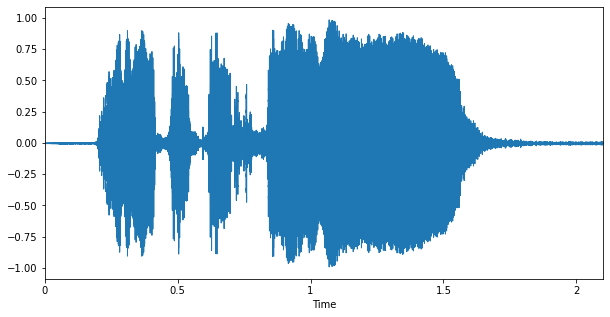

In [84]:
'''
Let's now look at some sample data for each emotion
to get an idea of the quality of the data to be used
'''

# Use Librosa library display and play sample speech
# This sample is for Angry emotion
fname = dtsets_df._get_value(10, 'path')
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

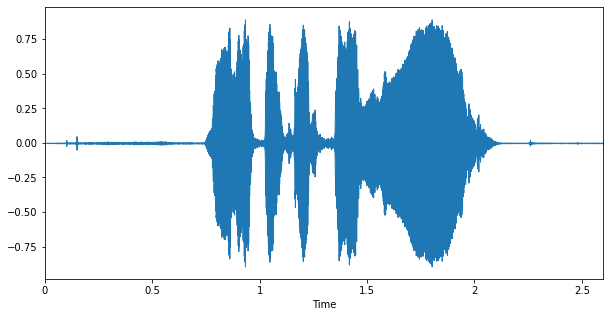

In [85]:
# This sample is for Happy emotion
fname = dtsets_df._get_value(160, 'path')
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

/content/drive/MyDrive/DataSpeechs/Erzal/Recording_127.wav


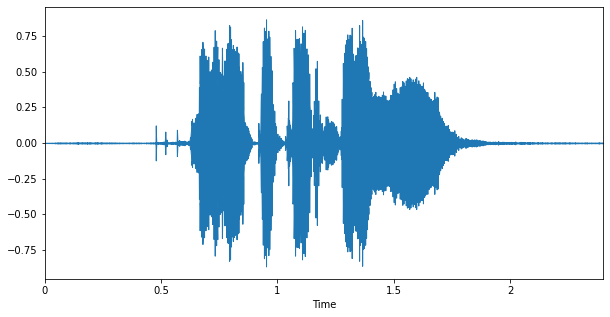

In [86]:
# This sample is for Disappointed emotion
fname = dtsets_df._get_value(102, 'path')
print(fname)
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

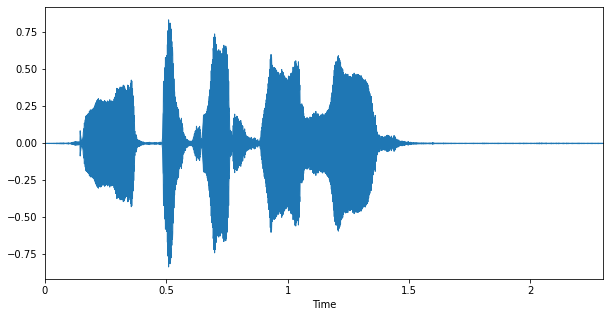

In [87]:
# This sample is for Sad emotion
fname = dtsets_df._get_value(393, 'path')
#print(fname)
data, sampling_rate = librosa.load(fname)
plt.figure(figsize=(10, 5))
librosa.display.waveplot(data, sr=sampling_rate)

# Lets play the audio 
ipd.Audio(fname)

###Data Augmentation

In [ ]:
def noise(signal):
  """
  Adding White Noise.
  """
  #signal, s_rate = lbr.load(wav, duration=2, sr=None)
  noise_amp = 0.01*np.random.uniform()*np.amax(signal)   # more noise reduce the value to 0.5
  signal = signal + noise_amp * np.random.normal(size=signal.shape[0])
  return signal

def stretch(signal, rate=0.8):
  """
  Streching the Sound. Note that this expands the dataset slightly
  """
  #signal, s_rate = lbr.load(wav, duration=2, sr=None)
  signal = librosa.effects.time_stretch(signal, rate)
  return signal

def speedNpitch(signal):
  """
  Speed and Pitch Tuning.
  """
  #signal, s_rate = lbr.load(wav, duration=2, sr=None)
  length_change = np.random.uniform(low=0.8, high = 1)
  speed_fac = 1.2  / length_change
  tmp = np.interp(np.arange(0, len(signal), speed_fac), np.arange(0, len(signal)), signal)
  minlen = min(signal.shape[0], tmp.shape[0])
  signal *= 0
  signal[0:minlen] = tmp[0:minlen]
  return signal

## Linear Predictive Coding (LPC)

In [ ]:
def LPC_feature(wav, order=8):
  # Define LPF Features variable
  lpc_features = []

  # Read speech signal
  signal, s_rate = librosa.load(wav, duration=2, sr=None)

  # Pre-Emphasis
  emphasized_signal = librosa.effects.preemphasis(signal, coef=0.97)

  # Frame Blocking and Windowing
  '''
  frames_win = np.abs(lbr.stft(emphasized_signal)) # using kind of hann window
  idx_frame = len(frames_win)//2
  frames_win = frames_win[idx_frame]
  '''

  # Autocorrelation
  autocorrelation = sig.fftconvolve(emphasized_signal, emphasized_signal[::-1])
  autocorr_coeff = autocorrelation[autocorrelation.size//2:][:(order + 1)]      # Autocorrelation Coefficients

  # LPC features
  lpc_coeff_ld = lazy_lpc.levinson_durbin(autocorr_coeff, 3)
  lpc_features = lpc_coeff_ld.numerator[1:]
  
  return lpc_features

In [ ]:
LPC_feature('/content/drive/MyDrive/Dataset TA/NewDataPrimer/Bahagia/Aka Bahagia 1.wav')

[-0.924572209945653, 0.7073411839646861, -0.37092528522518536]

In [ ]:
def load_dataset():
  sounds, emotions = [], []

  for dirname, _, filenames in os.walk(dtsets):
    for filename in filenames:
      #print(os.path.join(dirname, filename))
      sounds.append(os.path.join(dirname, filename))
      #print(filename)
      label = filename.split(' ')[-2]
      #print(label)
      emotions.append(label.lower())
  return {'Audio': sounds, 'Emotion': emotions}

In [ ]:
import time

start_time = time.time()
Trial_dict = load_dataset()
print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 0.0053293704986572266 seconds ---


In [ ]:
audio = Trial_dict['Audio']
label = Trial_dict['Emotion']

data = pd.DataFrame(label, columns = ['Emotion'])
data = pd.concat([data, pd.DataFrame(audio, columns = ['Path'])], axis=1)
data.head(-1)

,Emotion,Path
0,bahagia,/content/drive/MyDrive/Dataset TA/NewDataPrime...
1,bahagia,/content/drive/MyDrive/Dataset TA/NewDataPrime...
2,bahagia,/content/drive/MyDrive/Dataset TA/NewDataPrime...
3,bahagia,/content/drive/MyDrive/Dataset TA/NewDataPrime...
4,bahagia,/content/drive/MyDrive/Dataset TA/NewDataPrime...
...,...,...
74,marah,/content/drive/MyDrive/Dataset TA/NewDataPrime...
75,marah,/content/drive/MyDrive/Dataset TA/NewDataPrime...
76,marah,/content/drive/MyDrive/Dataset TA/NewDataPrime...
77,marah,/content/drive/MyDrive/Dataset TA/NewDataPrime...


##Features Engineering

## Next (Soon...)